<a href="https://colab.research.google.com/github/groda/big_data/blob/master/Apache_Sedona_with_PySpark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


<a href="https://github.com/groda/big_data"><div><img src="https://github.com/groda/big_data/blob/master/logo_bdb.png?raw=true" align=right width="90" alt="Logo Big Data for Beginners"></div></a>
# Apache Sedona with PySpark

Apache Sedona™ is a prime example of a distributed engine built on top of Spark, specifically designed for geographic data processing.

The home page describes Apache Sedona ([https://sedona.apache.org/](https://sedona.apache.org/)) as:

> *a cluster computing system for processing large-scale spatial data. Sedona extends existing cluster computing systems, such as Apache Spark, Apache Flink, and Snowflake, with a set of out-of-the-box distributed Spatial Datasets and Spatial SQL that efficiently load, process, and analyze large-scale spatial data across machines.*

In this notebook we are going to execute a basic Sedona demonstration using PySpark. The Sedona notebook starts below at [Apache Sedona Core demo](#scrollTo=Apache_Sedona_Core_demo).



## Install Apache Sedona, PySpark, and required libraries

To start with, we are going to install `apache-sedona` and PySpark making sure that we have the desired Spark version.


The required packages are specified in this [Pipfile](https://github.com/apache/sedona/blob/master/python/Pipfile) under `[packages]`:

```
[packages]
pandas="<=1.5.3"
geopandas="*"
shapely=">=1.7.0"
pyspark=">=2.3.0"
attrs="*"
pyarrow="*"
keplergl = "==0.3.2"
pydeck = "===0.8.0"
rasterio = ">=1.2.10"
```

Install Apache Sedona without Spark. To install Spark as well you can use `pip install apache-sedona[spark]` but we chose to use the Spark engine that comes with PySpark.

In [1]:
!pip install apache-sedona

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.2/174.2 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 41.1 MB/s eta 0:00:00


For the sake of this tutorial we are going to use the Spark engine that is included in the Pyspark distribution. Since Sedona needs Spark $3.4.0$ we need to make sure that we choose the correct PySpark version.

In [2]:
!pip install pyspark==3.4.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317122 sha256=3f82436ddf437a4a28b4d9ad489ffbe7458accd1eecaf1f0bf084627377b30a9
  Stored in directory: /root/.cache/pip/wheels/7b/1b/4b/3363a1d04368e7ff0d408e57ff57966fcdf00583774e761327
Successfully built pyspark


Verify that PySpark is using Spark version $3.4.0$.

In [3]:
!pyspark --version

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /___/ .__/\_,_/_/ /_/\_\   version 3.4.0
      /_/
                        
Using Scala version 2.12.17, OpenJDK 64-Bit Server VM, 11.0.22
Branch HEAD
Compiled by user xinrong.meng on 2023-04-07T02:18:01Z
Revision 87a5442f7ed96b11051d8a9333476d080054e5a0
Url https://github.com/apache/spark
Type --help for more information.


### Install Geopandas

The libraries `geopandas` and `shapely` are available by default on Google Colab.

In [4]:
!pip install geopandas

In [5]:
!pip install shapely

## Download the data

Since the data for the demo is in the Sedona's Github repository, we are going to clone Sedona's GitHub source code and copy the `data` folder under the current directory. We actually do not need the whole repository, just the `data` folder.

In [6]:
%%bash

[ -d sedona ] || git clone https://github.com/apache/sedona.git

cp -r sedona/docs/usecases/data ./

Cloning into 'sedona'...
Updating files: 100% (1266/1266), done.


Verify the presence of data in the designated `data` folder.

In [7]:
!ls data

arealm-small.csv	 gis_osm_pois_free_1.shp	 primaryroads-polygon.csv
county_small.tsv	 gis_osm_pois_free_1.shx	 raster
county_small_wkb.tsv	 ne_50m_admin_0_countries_lakes  testpoint.csv
gis_osm_pois_free_1.cpg  ne_50m_airports		 testPolygon.json
gis_osm_pois_free_1.dbf  polygon			 zcta510-small.csv
gis_osm_pois_free_1.prj  primaryroads-linestring.csv


# Apache Sedona Core demo

The notebook is available at the following link: https://github.com/apache/sedona/blob/master/docs/usecases/ApacheSedonaCore.ipynb.

Refer to https://mvnrepository.com/artifact/org.apache.sedona/sedona-spark-3.4 for making sense of packages and versions.




```
Licensed to the Apache Software Foundation (ASF) under one
or more contributor license agreements.  See the NOTICE file
distributed with this work for additional information
regarding copyright ownership.  The ASF licenses this file
to you under the Apache License, Version 2.0 (the
"License"); you may not use this file except in compliance
with the License.  You may obtain a copy of the License at
  http://www.apache.org/licenses/LICENSE-2.0
Unless required by applicable law or agreed to in writing,
software distributed under the License is distributed on an
"AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY
KIND, either express or implied.  See the License for the
specific language governing permissions and limitations
under the License.
```

In [8]:
from pyspark.sql import SparkSession
from pyspark import StorageLevel
import geopandas as gpd
import pandas as pd
from pyspark.sql.types import StructType
from pyspark.sql.types import StructField
from pyspark.sql.types import StringType
from pyspark.sql.types import LongType
from shapely.geometry import Point
from shapely.geometry import Polygon

from sedona.spark import *
from sedona.core.geom.envelope import Envelope

Note: the next cell might take a while to execute. Stretch your legs and contemplate the mysteries of the universe in the meantime. Hang tight!

In [9]:
config = SedonaContext.builder() .\
    config('spark.jars.packages',
           'org.apache.sedona:sedona-spark-3.4_2.12:1.6.0,'
           'org.datasyslab:geotools-wrapper:1.6.0-28.2,'
           'uk.co.gresearch.spark:spark-extension_2.12:2.11.0-3.4'). \
    getOrCreate()


sedona = SedonaContext.create(config)

In [10]:
sc = sedona.sparkContext
sc

<SparkContext master=local[*] appName=pyspark-shell>

`config` is the Spark session

In [11]:
type(config)

pyspark.sql.session.SparkSession

# Create SpatialRDD

## Reading to PointRDD from CSV file

We now want load the CSV file into Apache Sedona PointRDD
```
testattribute0,-88.331492,32.324142,testattribute1,testattribute2
testattribute0,-88.175933,32.360763,testattribute1,testattribute2
testattribute0,-88.388954,32.357073,testattribute1,testattribute2
testattribute0,-88.221102,32.35078,testattribute1,testattribute2
testattribute0,-88.323995,32.950671,testattribute1,testattribute2
testattribute0,-88.231077,32.700812,testattribute1,testattribute2
```

In [12]:
!head data/arealm-small.csv

testattribute0,-88.331492,32.324142,testattribute1,testattribute2
testattribute0,-88.175933,32.360763,testattribute1,testattribute2
testattribute0,-88.388954,32.357073,testattribute1,testattribute2
testattribute0,-88.221102,32.35078,testattribute1,testattribute2
testattribute0,-88.323995,32.950671,testattribute1,testattribute2
testattribute0,-88.231077,32.700812,testattribute1,testattribute2
testattribute0,-88.349276,32.548266,testattribute1,testattribute2
testattribute0,-88.304259,32.488903,testattribute1,testattribute2
testattribute0,-88.182481,32.59966,testattribute1,testattribute2
testattribute0,-86.955186,32.617088,testattribute1,testattribute2


In [13]:
point_rdd = PointRDD(sc, "data/arealm-small.csv", 1, FileDataSplitter.CSV, True, 10)

In [14]:
## Getting approximate total count
point_rdd.approximateTotalCount

3000

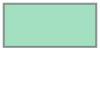

In [15]:
# getting boundary for PointRDD or any other SpatialRDD, it returns Enelope object which inherits from
# shapely.geometry.Polygon
point_rdd.boundary()

In [16]:
# To run analyze please use function analyze
point_rdd.analyze()

True

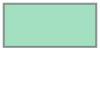

In [17]:
# Finding boundary envelope for PointRDD or any other SpatialRDD, it returns Enelope object which inherits from
# shapely.geometry.Polygon
point_rdd.boundaryEnvelope

In [18]:
# Calculate number of records without duplicates
point_rdd.countWithoutDuplicates()

2996

In [19]:
# Getting source epsg code
point_rdd.getSourceEpsgCode()

''

In [20]:
# Getting target epsg code
point_rdd.getTargetEpsgCode()

''

In [21]:
# Spatial partitioning data
point_rdd.spatialPartitioning(GridType.KDBTREE)

True

## Operations on RawSpatialRDD

rawSpatialRDD method returns RDD which consists of GeoData objects which has 2 attributes
<li> geom: shapely.geometry.BaseGeometry </li>
<li> userData: str </li>

You can use any operations on those objects and spread across machines

In [22]:
# take firs element
point_rdd.rawSpatialRDD.take(1)

[Geometry: Point userData: testattribute0	testattribute1	testattribute2]

In [23]:
# collect to Python list
point_rdd.rawSpatialRDD.collect()[:5]

[Geometry: Point userData: testattribute0	testattribute1	testattribute2,
 Geometry: Point userData: testattribute0	testattribute1	testattribute2,
 Geometry: Point userData: testattribute0	testattribute1	testattribute2,
 Geometry: Point userData: testattribute0	testattribute1	testattribute2,
 Geometry: Point userData: testattribute0	testattribute1	testattribute2]

In [24]:
# apply map functions, for example distance to Point(52 21)
point_rdd.rawSpatialRDD.map(lambda x: x.geom.distance(Point(21, 52))).take(5)

[111.08786851399313,
 110.92828303170774,
 111.1385974283527,
 110.97450594034112,
 110.97122518072091]

## Transforming to GeoPandas

## Loaded data can be transformed to GeoPandas DataFrame in a few ways

### Directly from RDD

In [25]:
point_rdd_to_geo = point_rdd.rawSpatialRDD.map(lambda x: [x.geom, *x.getUserData().split("\t")])

In [26]:
point_gdf = gpd.GeoDataFrame(
    point_rdd_to_geo.collect(), columns=["geom", "attr1", "attr2", "attr3"], geometry="geom"
)

In [27]:
point_gdf[:5]

,geom,attr1,attr2,attr3
0,POINT (-88.33149 32.32414),testattribute0,testattribute1,testattribute2
1,POINT (-88.17593 32.36076),testattribute0,testattribute1,testattribute2
2,POINT (-88.38895 32.35707),testattribute0,testattribute1,testattribute2
3,POINT (-88.22110 32.35078),testattribute0,testattribute1,testattribute2
4,POINT (-88.32399 32.95067),testattribute0,testattribute1,testattribute2


### Using Adapter

In [28]:
# Adapter allows you to convert geospatial data types introduced with sedona to other ones

In [29]:
spatial_df = Adapter.\
    toDf(point_rdd, ["attr1", "attr2", "attr3"], sedona).\
    createOrReplaceTempView("spatial_df")

spatial_gdf = sedona.sql("Select attr1, attr2, attr3, geometry as geom from spatial_df")

In [30]:
spatial_gdf.show(5, False)

+--------------+--------------+--------------+----------------------------+
|attr1         |attr2         |attr3         |geom                        |
+--------------+--------------+--------------+----------------------------+
|testattribute0|testattribute1|testattribute2|POINT (-88.331492 32.324142)|
|testattribute0|testattribute1|testattribute2|POINT (-88.175933 32.360763)|
|testattribute0|testattribute1|testattribute2|POINT (-88.388954 32.357073)|
|testattribute0|testattribute1|testattribute2|POINT (-88.221102 32.35078) |
|testattribute0|testattribute1|testattribute2|POINT (-88.323995 32.950671)|
+--------------+--------------+--------------+----------------------------+
only showing top 5 rows



In [31]:
gpd.GeoDataFrame(spatial_gdf.toPandas(), geometry="geom")[:5]

,attr1,attr2,attr3,geom
0,testattribute0,testattribute1,testattribute2,POINT (-88.33149 32.32414)
1,testattribute0,testattribute1,testattribute2,POINT (-88.17593 32.36076)
2,testattribute0,testattribute1,testattribute2,POINT (-88.38895 32.35707)
3,testattribute0,testattribute1,testattribute2,POINT (-88.22110 32.35078)
4,testattribute0,testattribute1,testattribute2,POINT (-88.32399 32.95067)


### With DataFrame creation

In [32]:
schema = StructType(
    [
        StructField("geometry", GeometryType(), False),
        StructField("attr1", StringType(), False),
        StructField("attr2", StringType(), False),
        StructField("attr3", StringType(), False),
    ]
)

In [33]:
geo_df = sedona.createDataFrame(point_rdd_to_geo, schema, verifySchema=False)

In [34]:
gpd.GeoDataFrame(geo_df.toPandas(), geometry="geometry")[:5]

,geometry,attr1,attr2,attr3
0,POINT (-88.33149 32.32414),testattribute0,testattribute1,testattribute2
1,POINT (-88.17593 32.36076),testattribute0,testattribute1,testattribute2
2,POINT (-88.38895 32.35707),testattribute0,testattribute1,testattribute2
3,POINT (-88.22110 32.35078),testattribute0,testattribute1,testattribute2
4,POINT (-88.32399 32.95067),testattribute0,testattribute1,testattribute2


# Load Typed SpatialRDDs

Currently The library supports 5 typed SpatialRDDs:
<li> RectangleRDD </li>
<li> PointRDD </li>
<li> PolygonRDD </li>
<li> LineStringRDD </li>
<li> CircleRDD </li>

In [35]:
rectangle_rdd = RectangleRDD(sc, "data/zcta510-small.csv", FileDataSplitter.CSV, True, 11)
point_rdd = PointRDD(sc, "data/arealm-small.csv", 1, FileDataSplitter.CSV, False, 11)
polygon_rdd = PolygonRDD(sc, "data/primaryroads-polygon.csv", FileDataSplitter.CSV, True, 11)
linestring_rdd = LineStringRDD(sc, "data/primaryroads-linestring.csv", FileDataSplitter.CSV, True)

In [36]:
rectangle_rdd.analyze()
point_rdd.analyze()
polygon_rdd.analyze()
linestring_rdd.analyze()

True

# Spatial Partitioning

Apache Sedona spatial partitioning method can significantly speed up the join query. Three spatial partitioning methods are available: KDB-Tree, Quad-Tree and R-Tree. Two SpatialRDD must be partitioned by the same way.

In [37]:
point_rdd.spatialPartitioning(GridType.KDBTREE)

True

# Create Index

Apache Sedona provides two types of spatial indexes, Quad-Tree and R-Tree. Once you specify an index type, Apache Sedona will build a local tree index on each of the SpatialRDD partition.

In [38]:
point_rdd.buildIndex(IndexType.RTREE, True)

# SpatialJoin

Spatial join is operation which combines data based on spatial relations like:
<li> intersects </li>
<li> touches </li>
<li> within </li>
<li> etc </li>

To Use Spatial Join in GeoPyspark library please use JoinQuery object, which has implemented below methods:
```python
SpatialJoinQuery(spatialRDD: SpatialRDD, queryRDD: SpatialRDD, useIndex: bool, considerBoundaryIntersection: bool) -> RDD

DistanceJoinQuery(spatialRDD: SpatialRDD, queryRDD: SpatialRDD, useIndex: bool, considerBoundaryIntersection: bool) -> RDD

spatialJoin(queryWindowRDD: SpatialRDD, objectRDD: SpatialRDD, joinParams: JoinParams) -> RDD

DistanceJoinQueryFlat(spatialRDD: SpatialRDD, queryRDD: SpatialRDD, useIndex: bool, considerBoundaryIntersection: bool) -> RDD

SpatialJoinQueryFlat(spatialRDD: SpatialRDD, queryRDD: SpatialRDD, useIndex: bool, considerBoundaryIntersection: bool) -> RDD

```

## Example SpatialJoinQueryFlat PointRDD with RectangleRDD

In [39]:
# partitioning the data
point_rdd.spatialPartitioning(GridType.KDBTREE)
rectangle_rdd.spatialPartitioning(point_rdd.getPartitioner())
# building an index
point_rdd.buildIndex(IndexType.RTREE, True)
# Perform Spatial Join Query
result = JoinQuery.SpatialJoinQueryFlat(point_rdd, rectangle_rdd, False, True)

As result we will get RDD[GeoData, GeoData]
It can be used like any other Python RDD. You can use map, take, collect and other functions  

In [40]:
result

MapPartitionsRDD[63] at map at FlatPairRddConverter.scala:30

In [41]:
result.take(2)

[[Geometry: Polygon userData: , Geometry: Point userData: ],
 [Geometry: Polygon userData: , Geometry: Point userData: ]]

In [42]:
result.collect()[:3]

[[Geometry: Polygon userData: , Geometry: Point userData: ],
 [Geometry: Polygon userData: , Geometry: Point userData: ],
 [Geometry: Polygon userData: , Geometry: Point userData: ]]

In [43]:
# getting distance using SpatialObjects
result.map(lambda x: x[0].geom.distance(x[1].geom)).take(5)

[0.0, 0.0, 0.0, 0.0, 0.0]

In [44]:
# getting area of polygon data
result.map(lambda x: x[0].geom.area).take(5)

[0.05189354027999942,
 0.057069904940998895,
 0.051572544132000575,
 0.051572544132000575,
 0.051572544132000575]

In [45]:
# Base on result you can create DataFrame object, using map function and build DataFrame from RDD
schema = StructType(
    [
        StructField("geom_left", GeometryType(), False),
        StructField("geom_right", GeometryType(), False)
    ]
)

In [46]:
# Set verifySchema to False
spatial_join_result = result.map(lambda x: [x[0].geom, x[1].geom])
sedona.createDataFrame(spatial_join_result, schema, verifySchema=False).show(5, True)

+--------------------+--------------------+
|           geom_left|          geom_right|
+--------------------+--------------------+
|POLYGON ((-87.092...|POINT (-86.94719 ...|
|POLYGON ((-87.285...|POINT (-87.186331...|
|POLYGON ((-87.082...|POINT (-87.059583...|
|POLYGON ((-87.082...|POINT (-87.075409...|
|POLYGON ((-87.082...|POINT (-87.08084 ...|
+--------------------+--------------------+
only showing top 5 rows



In [47]:
# Above code produces DataFrame with geometry Data type
sedona.createDataFrame(spatial_join_result, schema, verifySchema=False).printSchema()

root
 |-- geom_left: geometry (nullable = false)
 |-- geom_right: geometry (nullable = false)



We can create DataFrame object from Spatial Pair RDD using Adapter object as follows

In [48]:
Adapter.toDf(result, ["attr1"], ["attr2"], sedona).show(5, True)

+--------------------+-----+--------------------+-----+
|              geom_1|attr1|              geom_2|attr2|
+--------------------+-----+--------------------+-----+
|POLYGON ((-87.092...|     |POINT (-86.94719 ...|     |
|POLYGON ((-87.285...|     |POINT (-87.186331...|     |
|POLYGON ((-87.082...|     |POINT (-87.059583...|     |
|POLYGON ((-87.082...|     |POINT (-87.075409...|     |
|POLYGON ((-87.082...|     |POINT (-87.08084 ...|     |
+--------------------+-----+--------------------+-----+
only showing top 5 rows



This also produce DataFrame with geometry DataType

In [49]:
Adapter.toDf(result, ["attr1"], ["attr2"], sedona).printSchema()

root
 |-- geom_1: geometry (nullable = true)
 |-- attr1: string (nullable = true)
 |-- geom_2: geometry (nullable = true)
 |-- attr2: string (nullable = true)



We can create RDD which will be of type RDD[GeoData, List[GeoData]]
We can for example calculate number of Points within some polygon data

To do that we can use code specified below

In [50]:
point_rdd.spatialPartitioning(GridType.KDBTREE)
rectangle_rdd.spatialPartitioning(point_rdd.getPartitioner())

In [51]:
spatial_join_result_non_flat = JoinQuery.SpatialJoinQuery(point_rdd, rectangle_rdd, False, True)

In [52]:
# number of point for each polygon
number_of_points = spatial_join_result_non_flat.map(lambda x: [x[0].geom, x[1].__len__()])

In [53]:
schema = StructType([
    StructField("geometry", GeometryType(), False),
    StructField("number_of_points", LongType(), False)
])

In [54]:
sedona.createDataFrame(number_of_points, schema, verifySchema=False).show()

+--------------------+----------------+
|            geometry|number_of_points|
+--------------------+----------------+
|POLYGON ((-87.082...|              12|
|POLYGON ((-87.229...|               7|
|POLYGON ((-86.749...|               4|
|POLYGON ((-87.285...|              26|
|POLYGON ((-87.114...|              15|
|POLYGON ((-86.816...|               6|
|POLYGON ((-87.092...|               5|
|POLYGON ((-86.697...|               1|
|POLYGON ((-86.860...|              12|
|POLYGON ((-87.105...|              15|
+--------------------+----------------+



# KNNQuery

Spatial KNNQuery is operation which help us find answer which k number of geometries lays closest to other geometry.

For Example:
    5 closest Shops to your home. To use Spatial KNNQuery please use object
<b> KNNQuery </b> which has one method:
```python
SpatialKnnQuery(spatialRDD: SpatialRDD, originalQueryPoint: BaseGeometry, k: int,  useIndex: bool)-> List[GeoData]
```

### Finds 5 closest points from PointRDD to given Point

In [55]:
result = KNNQuery.SpatialKnnQuery(point_rdd, Point(-84.01, 34.01), 5, False)

In [56]:
result

[Geometry: Point userData: ,
 Geometry: Point userData: ,
 Geometry: Point userData: ,
 Geometry: Point userData: ,
 Geometry: Point userData: ]

As Reference geometry you can also use Polygon or LineString object

In [57]:
polygon = Polygon(
    [(-84.237756, 33.904859), (-84.237756, 34.090426),
     (-83.833011, 34.090426), (-83.833011, 33.904859),
     (-84.237756, 33.904859)
    ])
polygons_nearby = KNNQuery.SpatialKnnQuery(polygon_rdd, polygon, 5, False)

In [58]:
polygons_nearby

[Geometry: Polygon userData: ,
 Geometry: Polygon userData: ,
 Geometry: Polygon userData: ,
 Geometry: Polygon userData: ,
 Geometry: Polygon userData: ]

In [59]:
polygons_nearby[0].geom.wkt

'POLYGON ((-83.993559 34.087259, -83.993559 34.131247, -83.959903 34.131247, -83.959903 34.087259, -83.993559 34.087259))'

# RangeQuery

A spatial range query takes as input a range query window and an SpatialRDD and returns all geometries that intersect / are fully covered by the query window.
RangeQuery has one method:

```python
SpatialRangeQuery(self, spatialRDD: SpatialRDD, rangeQueryWindow: BaseGeometry, considerBoundaryIntersection: bool, usingIndex: bool) -> RDD
```

In [60]:
from sedona.core.geom.envelope import Envelope

In [61]:
query_envelope = Envelope(-85.01, -60.01, 34.01, 50.01)

result_range_query = RangeQuery.SpatialRangeQuery(linestring_rdd, query_envelope, False, False)

In [62]:
result_range_query

MapPartitionsRDD[127] at map at GeometryRddConverter.scala:30

In [63]:
result_range_query.take(6)

[Geometry: LineString userData: ,
 Geometry: LineString userData: ,
 Geometry: LineString userData: ,
 Geometry: LineString userData: ,
 Geometry: LineString userData: ,
 Geometry: LineString userData: ]

In [64]:
# Creating DataFrame from result

In [65]:
schema = StructType([StructField("geometry", GeometryType(), False)])

In [66]:
sedona.createDataFrame(
    result_range_query.map(lambda x: [x.geom]),
    schema,
    verifySchema=False
).show(5, True)

+--------------------+
|            geometry|
+--------------------+
|LINESTRING (-72.1...|
|LINESTRING (-72.4...|
|LINESTRING (-72.4...|
|LINESTRING (-73.4...|
|LINESTRING (-73.6...|
+--------------------+
only showing top 5 rows



# Load From other Formats

GeoPyspark allows to load the data from other Data formats like:
<li> GeoJSON </li>
<li> Shapefile </li>
<li> WKB </li>
<li> WKT </li>

## ShapeFile - load to SpatialRDD

In [67]:
shape_rdd = ShapefileReader.readToGeometryRDD(sc, "data/polygon")

In [68]:
shape_rdd

In [69]:
Adapter.toDf(shape_rdd, sedona).show(5, True)

+--------------------+
|            geometry|
+--------------------+
|MULTIPOLYGON (((1...|
|MULTIPOLYGON (((-...|
|MULTIPOLYGON (((1...|
|POLYGON ((118.362...|
|MULTIPOLYGON (((-...|
+--------------------+
only showing top 5 rows



## GeoJSON - load to SpatialRDD

```
{ "type": "Feature", "properties": { "STATEFP": "01", "COUNTYFP": "077", "TRACTCE": "011501", "BLKGRPCE": "5", "AFFGEOID": "1500000US010770115015", "GEOID": "010770115015", "NAME": "5", "LSAD": "BG", "ALAND": 6844991, "AWATER": 32636 }, "geometry": { "type": "Polygon", "coordinates": [ [ [ -87.621765, 34.873444 ], [ -87.617535, 34.873369 ], [ -87.6123, 34.873337 ], [ -87.604049, 34.873303 ], [ -87.604033, 34.872316 ], [ -87.60415, 34.867502 ], [ -87.604218, 34.865687 ], [ -87.604409, 34.858537 ], [ -87.604018, 34.851336 ], [ -87.603716, 34.844829 ], [ -87.603696, 34.844307 ], [ -87.603673, 34.841884 ], [ -87.60372, 34.841003 ], [ -87.603879, 34.838423 ], [ -87.603888, 34.837682 ], [ -87.603889, 34.83763 ], [ -87.613127, 34.833938 ], [ -87.616451, 34.832699 ], [ -87.621041, 34.831431 ], [ -87.621056, 34.831526 ], [ -87.62112, 34.831925 ], [ -87.621603, 34.8352 ], [ -87.62158, 34.836087 ], [ -87.621383, 34.84329 ], [ -87.621359, 34.844438 ], [ -87.62129, 34.846387 ], [ -87.62119, 34.85053 ], [ -87.62144, 34.865379 ], [ -87.621765, 34.873444 ] ] ] } },
```

In [70]:
geo_json_rdd = GeoJsonReader.readToGeometryRDD(sc, "data/testPolygon.json")

In [71]:
geo_json_rdd

In [72]:
Adapter.toDf(geo_json_rdd, sedona).drop("AWATER").show(5, True)

+--------------------+-------+--------+-------+--------+--------------------+------------+----+----+--------+
|            geometry|STATEFP|COUNTYFP|TRACTCE|BLKGRPCE|            AFFGEOID|       GEOID|NAME|LSAD|   ALAND|
+--------------------+-------+--------+-------+--------+--------------------+------------+----+----+--------+
|POLYGON ((-87.621...|     01|     077| 011501|       5|1500000US01077011...|010770115015|   5|  BG| 6844991|
|POLYGON ((-85.719...|     01|     045| 021102|       4|1500000US01045021...|010450211024|   4|  BG|11360854|
|POLYGON ((-86.000...|     01|     055| 001300|       3|1500000US01055001...|010550013003|   3|  BG| 1378742|
|POLYGON ((-86.574...|     01|     089| 001700|       2|1500000US01089001...|010890017002|   2|  BG| 1040641|
|POLYGON ((-85.382...|     01|     069| 041400|       1|1500000US01069041...|010690414001|   1|  BG| 8243574|
+--------------------+-------+--------+-------+--------+--------------------+------------+----+----+--------+
only showi

## WKT - loading to SpatialRDD

In [73]:
wkt_rdd = WktReader.readToGeometryRDD(sc, "data/county_small.tsv", 0, True, False)

In [74]:
wkt_rdd

In [75]:
Adapter.toDf(wkt_rdd, sedona).printSchema()

root
 |-- geometry: geometry (nullable = true)



In [76]:
Adapter.toDf(wkt_rdd, sedona).show(5, True)

+--------------------+
|            geometry|
+--------------------+
|POLYGON ((-97.019...|
|POLYGON ((-123.43...|
|POLYGON ((-104.56...|
|POLYGON ((-96.910...|
|POLYGON ((-98.273...|
+--------------------+
only showing top 5 rows



## WKB - load to SpatialRDD

In [77]:
wkb_rdd = WkbReader.readToGeometryRDD(sc, "data/county_small_wkb.tsv", 0, True, False)

In [78]:
Adapter.toDf(wkb_rdd, sedona).show(5, True)

+--------------------+
|            geometry|
+--------------------+
|POLYGON ((-97.019...|
|POLYGON ((-123.43...|
|POLYGON ((-104.56...|
|POLYGON ((-96.910...|
|POLYGON ((-98.273...|
+--------------------+
only showing top 5 rows



## Converting RDD Spatial join result to DF directly, avoiding jvm python serde

In [79]:
point_rdd.spatialPartitioning(GridType.KDBTREE)
rectangle_rdd.spatialPartitioning(point_rdd.getPartitioner())
# building an index
point_rdd.buildIndex(IndexType.RTREE, True)
# Perform Spatial Join Query
result = JoinQueryRaw.SpatialJoinQueryFlat(point_rdd, rectangle_rdd, False, True)

In [80]:
# without passing column names, the result will contain only two geometries columns
geometry_df = Adapter.toDf(result, sedona)

In [81]:
geometry_df.printSchema()

root
 |-- leftgeometry: geometry (nullable = true)
 |-- rightgeometry: geometry (nullable = true)



In [82]:
geometry_df.show(5)

+--------------------+--------------------+
|        leftgeometry|       rightgeometry|
+--------------------+--------------------+
|POLYGON ((-87.285...|POINT (-87.186331...|
|POLYGON ((-87.229...|POINT (-87.204033...|
|POLYGON ((-87.229...|POINT (-87.204299...|
|POLYGON ((-87.229...|POINT (-87.19351 ...|
|POLYGON ((-87.229...|POINT (-87.18222 ...|
+--------------------+--------------------+
only showing top 5 rows



In [83]:
geometry_df.collect()[0]

Row(leftgeometry=<POLYGON ((-87.285 34.299, -87.285 34.514, -87.019 34.514, -87.019 34.299, -...>, rightgeometry=<POINT (-87.186 34.313)>)

## Passing column names

In [84]:
geometry_df = Adapter.toDf(result, ["left_user_data"], ["right_user_data"], sedona)

In [85]:
geometry_df.show(5)

+--------------------+--------------+--------------------+---------------+
|        leftgeometry|left_user_data|       rightgeometry|right_user_data|
+--------------------+--------------+--------------------+---------------+
|POLYGON ((-87.285...|              |POINT (-87.186331...|           null|
|POLYGON ((-87.229...|              |POINT (-87.204033...|           null|
|POLYGON ((-87.229...|              |POINT (-87.204299...|           null|
|POLYGON ((-87.229...|              |POINT (-87.19351 ...|           null|
|POLYGON ((-87.229...|              |POINT (-87.18222 ...|           null|
+--------------------+--------------+--------------------+---------------+
only showing top 5 rows



# Converting RDD Spatial join result to DF directly, avoiding jvm python serde

In [86]:
query_envelope = Envelope(-85.01, -60.01, 34.01, 50.01)

result_range_query = RangeQueryRaw.SpatialRangeQuery(linestring_rdd, query_envelope, False, False)

In [87]:
# converting to df
gdf = Adapter.toDf(result_range_query, sedona)

In [88]:
gdf.show(5)

+--------------------+
|            geometry|
+--------------------+
|LINESTRING (-72.1...|
|LINESTRING (-72.4...|
|LINESTRING (-72.4...|
|LINESTRING (-73.4...|
|LINESTRING (-73.6...|
+--------------------+
only showing top 5 rows



In [89]:
gdf.printSchema()

root
 |-- geometry: geometry (nullable = true)



In [90]:
# Passing column names
# converting to df
gdf_with_columns = Adapter.toDf(result_range_query, sedona, ["_c1"])

In [91]:
gdf_with_columns.show(5)

+--------------------+---+
|            geometry|_c1|
+--------------------+---+
|LINESTRING (-72.1...|   |
|LINESTRING (-72.4...|   |
|LINESTRING (-72.4...|   |
|LINESTRING (-73.4...|   |
|LINESTRING (-73.6...|   |
+--------------------+---+
only showing top 5 rows



In [92]:
gdf_with_columns.printSchema()

root
 |-- geometry: geometry (nullable = true)
 |-- _c1: string (nullable = true)



# Summary

We have shown how to install Sedona with Pyspark and run a basic example (source: https://github.com/apache/sedona/blob/master/docs/usecases/ApacheSedonaCore.ipynb) on Google Colab. This demo uses the Spark engine provided by PySpark.